In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "worldbank_data_exploration"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel('INFO')

# Dataset

In [3]:
from data_sources.load_dataset import load_time_series

time_series_dict, countries, years = load_time_series()

C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (C:\\Users\\MatiX\\anaconda3\\envs\\py39\\lib\\site-packages\\urllib3\\util\\__init__.py)', 'urllib3.util.ssl_ (C:\\Users\\MatiX\\anaconda3\\envs\\py39\\lib\\site-packages\\urllib3\\util\\ssl_.py)']. 
  curious_george.patch_all(thread=False, select=False)


In [4]:
len(countries), countries[:10]

(171,
 array(['Africa Eastern and Southern', 'Africa Western and Central',
        'Albania', 'Angola', 'Antigua and Barbuda', 'Arab World',
        'Argentina', 'Australia', 'Austria', 'Azerbaijan'], dtype=object))

In [5]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [6]:
len(time_series_dict), time_series_dict.keys()

(15,
 dict_keys(['Access to electricity (% of population)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'Life expectancy at birth, total (years)', 'Merchandise trade (% of GDP)', 'Military expenditure (% of GDP)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Population in the largest city (% of urban population)', 'Total natural resources rents (% of GDP)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']))

In [7]:
time_series_dict['Access to electricity (% of population)'].shape, time_series_dict['Total natural resources rents (% of GDP)'].shape

((171, 20), (171, 20))

In [8]:
X_all = np.vstack(list(time_series_dict.values()))
X_all.shape

(2565, 20)

# Train on all data

In [9]:
from sklearn.metrics import mean_absolute_error

from feature_extraction.utils import Normalizer
from feature_extraction import Autoencoder

## Utils

In [10]:
def plot_history(history, title, ymax=None, print_mae=True):
    plt.figure(figsize=(12, 8))
    
    plt.plot(np.arange(1, len(history['loss']) + 1), history['loss'])
    
    plt.ylim(bottom=0)
    if ymax is not None:
        plt.ylim(top=ymax)
        
    plt.title(f"{title} ({min(history['loss']):0.6f})")
    plt.grid()
    plt.show()
    
def plot_autoencoded(model, X, indices=[1, 100, 500, 821, 1000, 1250, 1500, 1872, 2000, 2137, 2560], rows=3, cols=4, figsize=(18, 11)):
    plt.figure(figsize=figsize)
    
    X_enc = model.predict(X)
    
    normalizer = Normalizer()
    X_norm = normalizer.fit_transform(X)
    X_enc_norm = normalizer.transform(X_enc)
    
    mae_list = [mean_absolute_error(x, x_enc) * 10_000 for x, x_enc in zip(X_norm, X_enc_norm)]
    indices = indices + [np.argmax(mae_list)]
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.plot(years, X[idx], label='true')
        plt.plot(years, X_enc[idx], label='autoencoded')
        plt.title(f'{idx:3}, mae: {mae_list[idx]:0.6f}', fontsize=10)
        
    plt.legend()
    plt.show()

In [11]:
N_BOTTLENECK = 4
INPUT_LEN = 20
ALL_PATH = f'{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/all'

## Train

In [12]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, 
                              model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=4000, verbose=0, lr_patience=120)

autoencoder_all.load_weights()

print(f'Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}')

81/81 [==============================] - 1s 3ms/step - loss: 71.1623
Loss: 71.162277


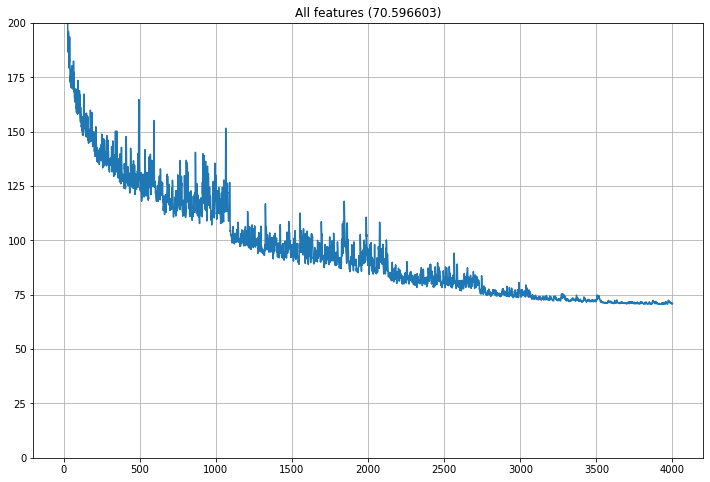

In [13]:
plot_history(autoencoder_all.history, 'All features', ymax=200)

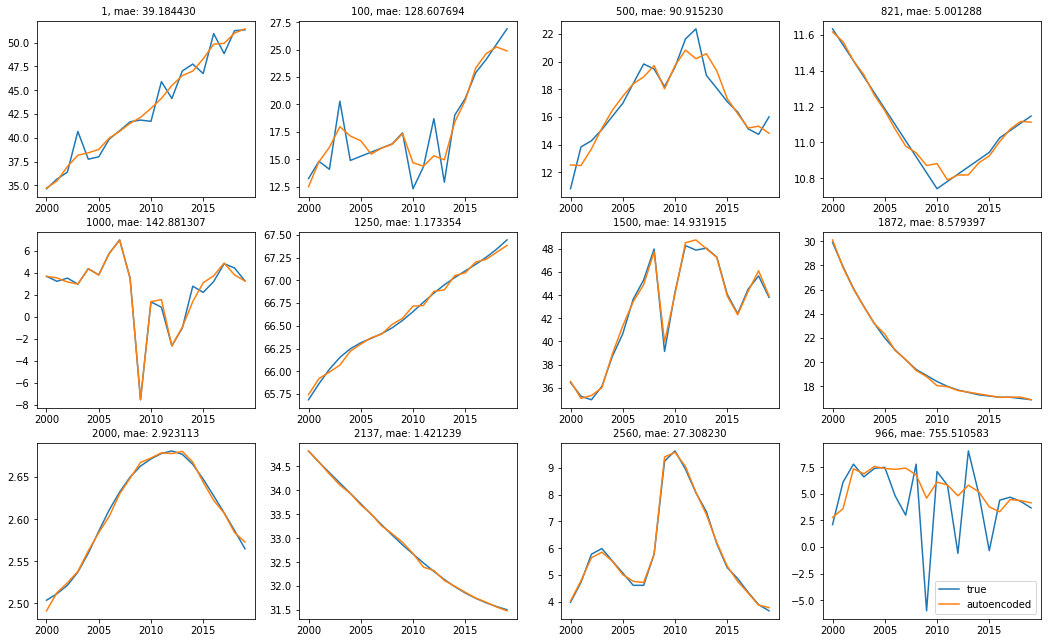

In [14]:
plot_autoencoded(autoencoder_all, X_all)

# Fine-tune for each time series type

In [15]:
for feature, X in list(time_series_dict.items()):
    print('===========================================================================================================================================')
    print(feature)
    print('===========================================================================================================================================')
    
    model_path = f'{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/{feature}'
    autoencoder = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=model_path)
    autoencoder.load_weights(path=ALL_PATH)
    
    # autoencoder.compile_and_train(X, n_epochs=2000, lr=0.001, verbose=0, lr_patience=100)
    
    autoencoder.load_weights()
    
    print(f'Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}')

Access to electricity (% of population)
6/6 [==============================] - 0s 3ms/step - loss: 22.2699
Loss: 16.265997. Before fine-tuning: 22.269926
Agriculture, forestry, and fishing, value added (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 84.2584
Loss: 66.372658. Before fine-tuning: 84.258438
Exports of goods and services (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 70.1232
Loss: 49.754711. Before fine-tuning: 70.123230
Fertility rate, total (births per woman)
6/6 [==============================] - 0s 3ms/step - loss: 16.5619
Loss: 10.911032. Before fine-tuning: 16.561857
Forest area (% of land area)
6/6 [==============================] - 0s 3ms/step - loss: 12.2066
Loss: 5.204057. Before fine-tuning: 12.206610
GDP growth (annual %)
6/6 [==============================] - 0s 3ms/step - loss: 187.3931
Loss: 146.215912. Before fine-tuning: 187.393082
Inflation, consumer prices (annual %)
6/6 [==============================] - 0s 3m

Access to electricity (% of population)
6/6 [==============================] - 0s 3ms/step - loss: 22.2699
Loss: 16.265997. Before fine-tuning: 22.269926


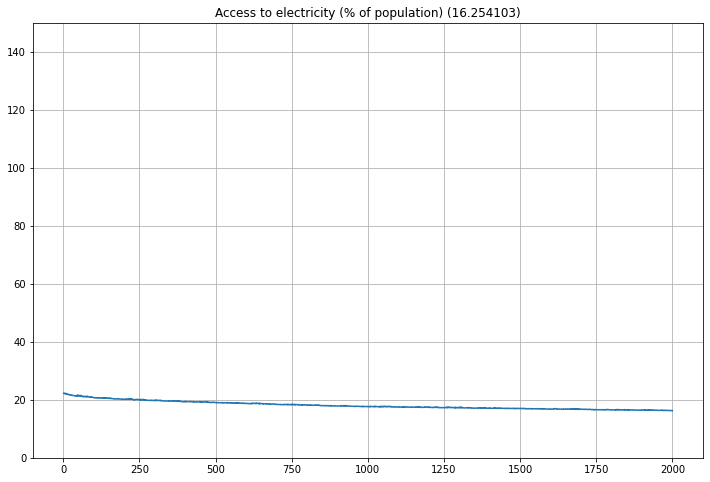

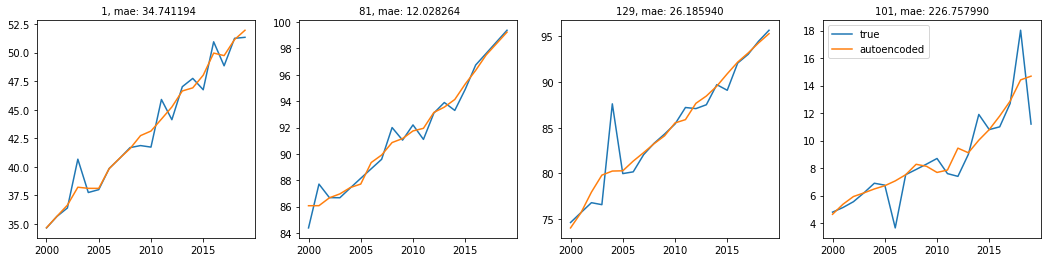

Agriculture, forestry, and fishing, value added (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 84.2584
Loss: 66.372658. Before fine-tuning: 84.258438


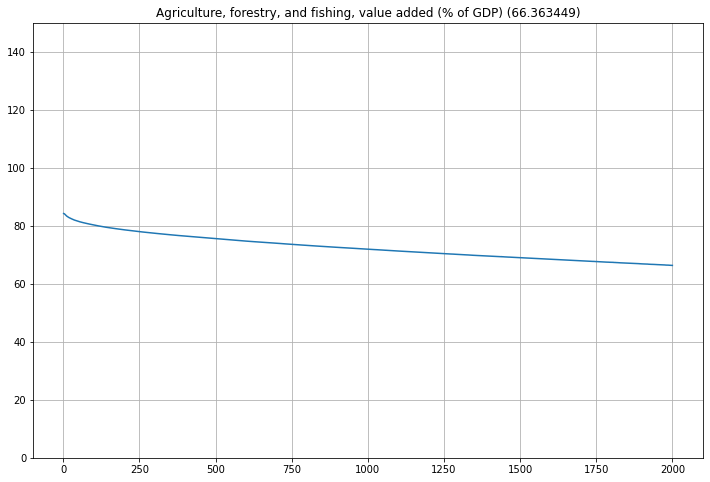

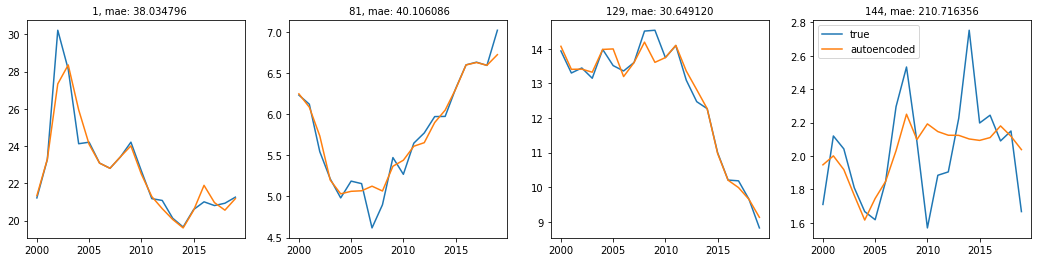

Exports of goods and services (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 70.1232
Loss: 49.754711. Before fine-tuning: 70.123230


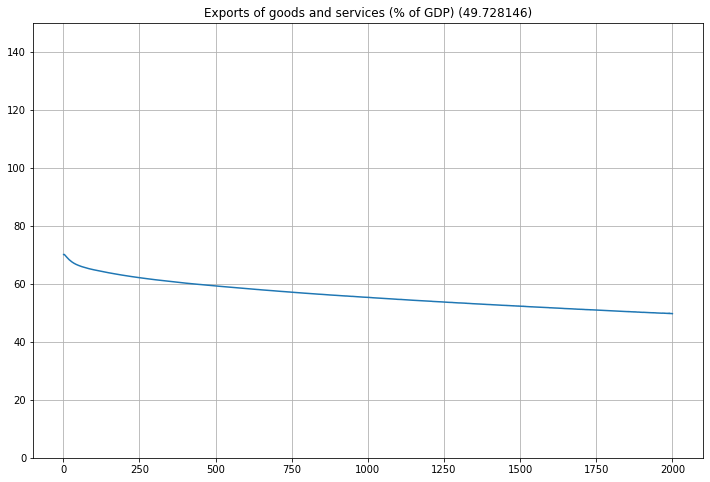

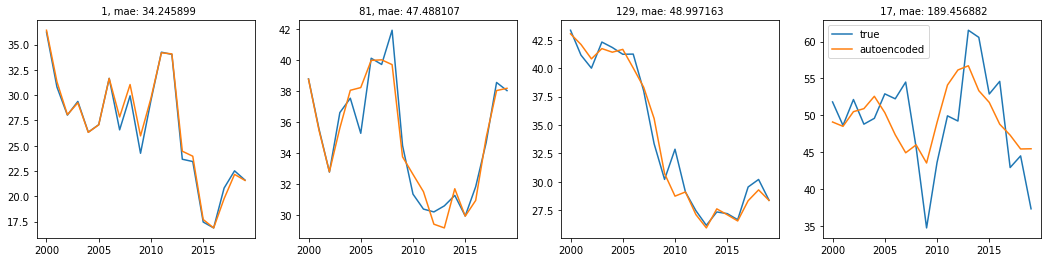

Fertility rate, total (births per woman)
6/6 [==============================] - 0s 3ms/step - loss: 16.5619
Loss: 10.911032. Before fine-tuning: 16.561857


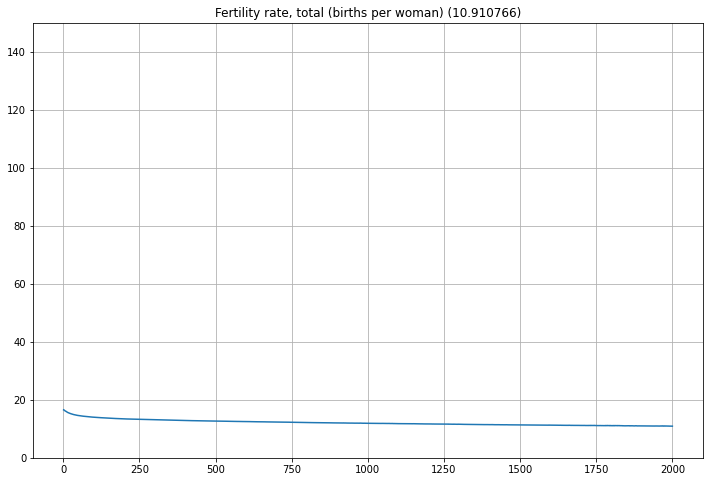

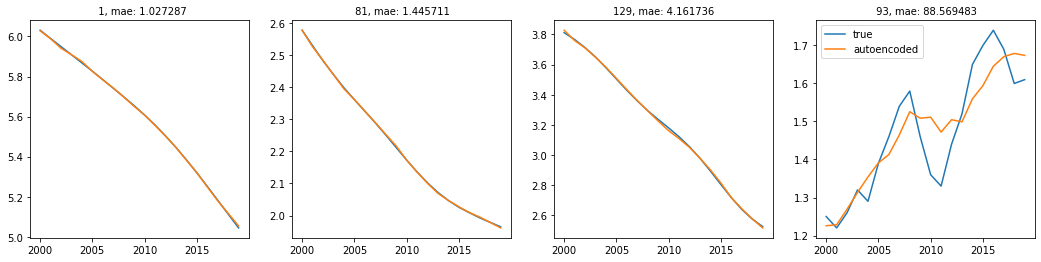

Forest area (% of land area)
6/6 [==============================] - 0s 3ms/step - loss: 12.2066
Loss: 5.204057. Before fine-tuning: 12.206610


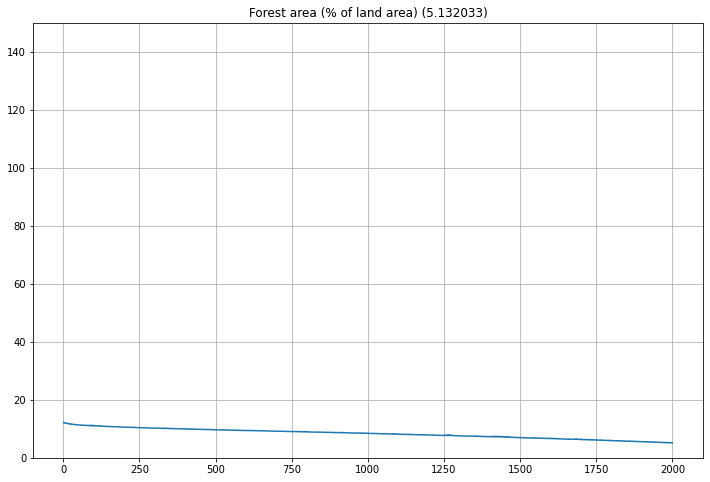

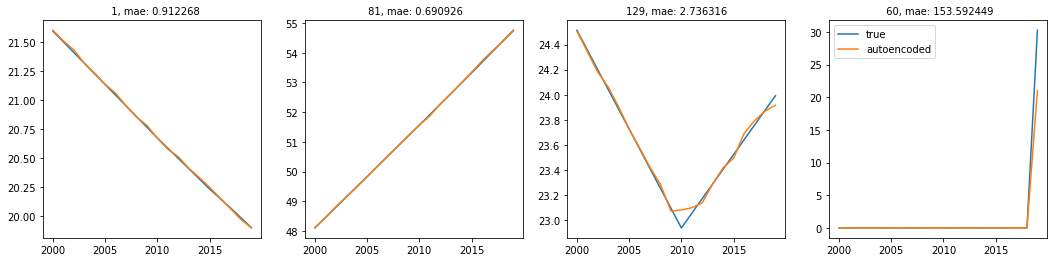

GDP growth (annual %)
6/6 [==============================] - 0s 3ms/step - loss: 187.3931
Loss: 146.215912. Before fine-tuning: 187.393082


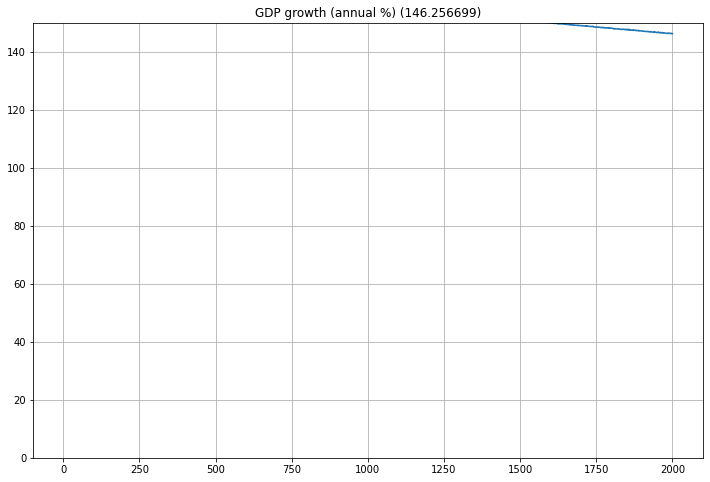

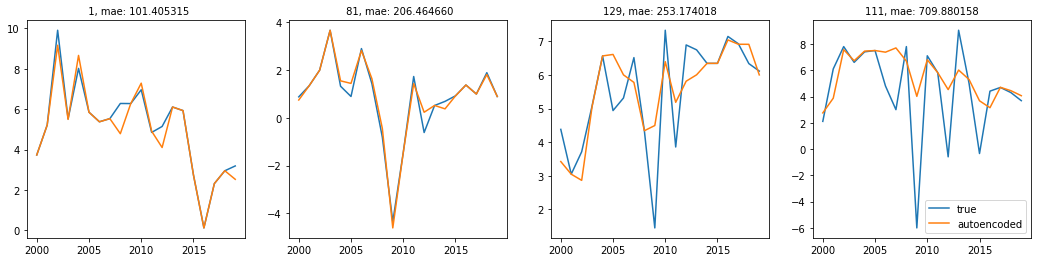

Inflation, consumer prices (annual %)
6/6 [==============================] - 0s 3ms/step - loss: 194.5288
Loss: 155.856766. Before fine-tuning: 194.528763


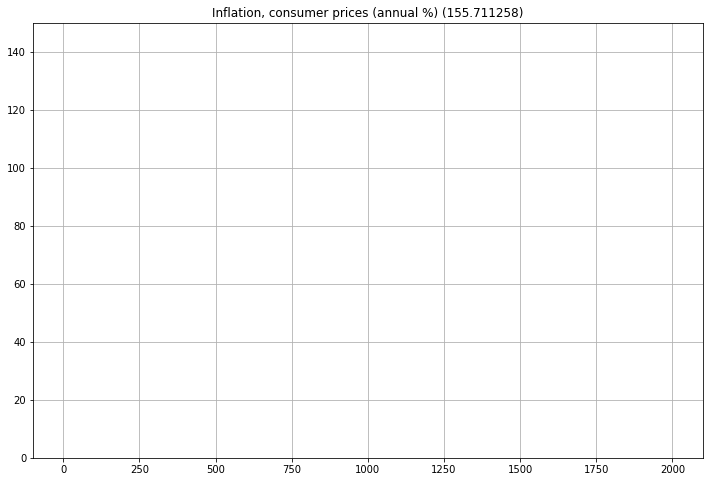

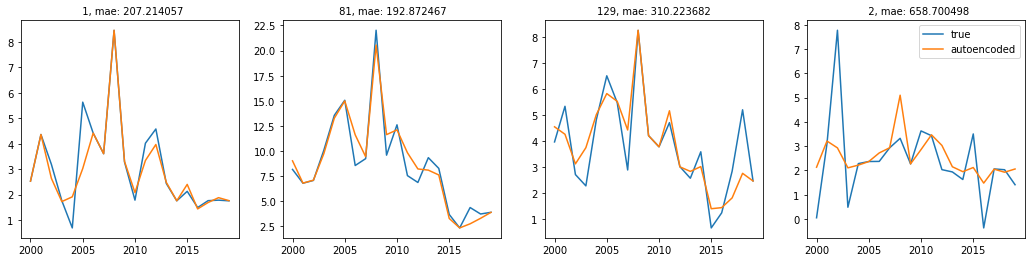

Life expectancy at birth, total (years)
6/6 [==============================] - 0s 3ms/step - loss: 2.5221
Loss: 1.599560. Before fine-tuning: 2.522062


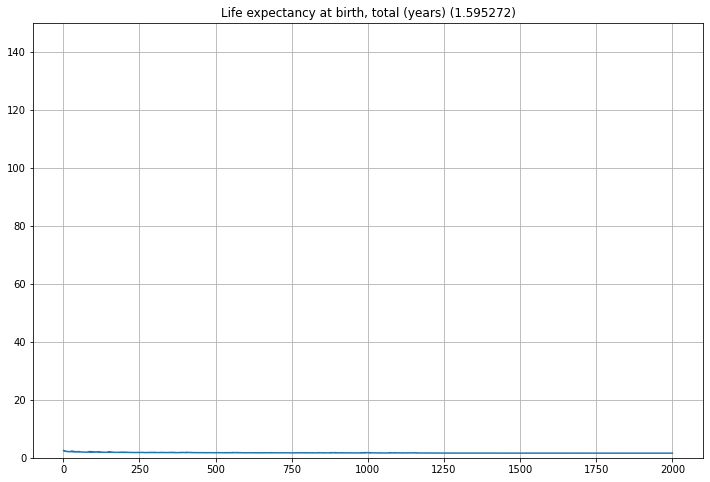

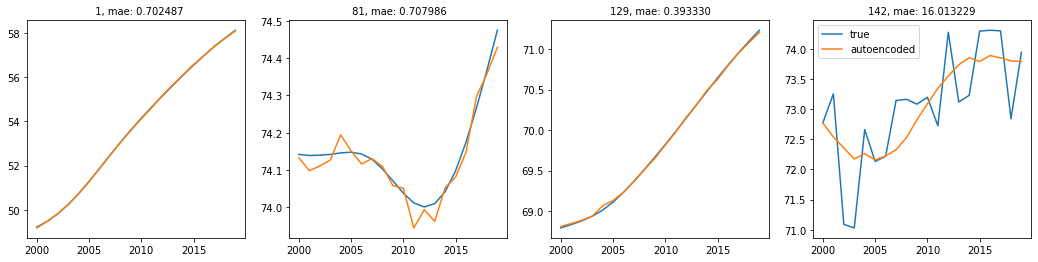

Merchandise trade (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 72.5716
Loss: 54.624210. Before fine-tuning: 72.571594


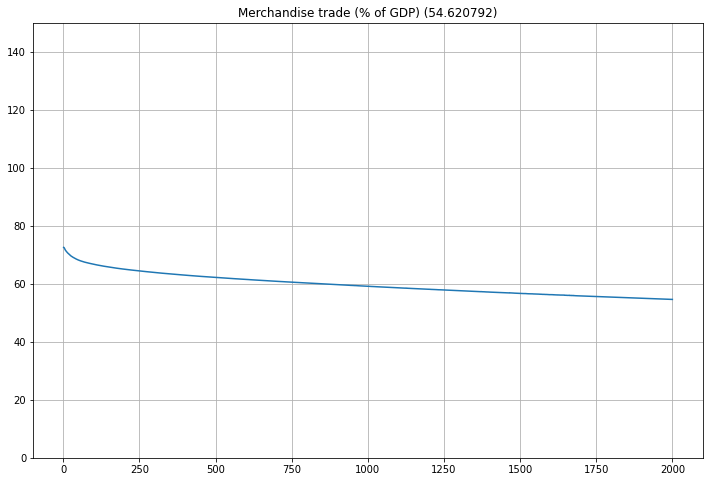

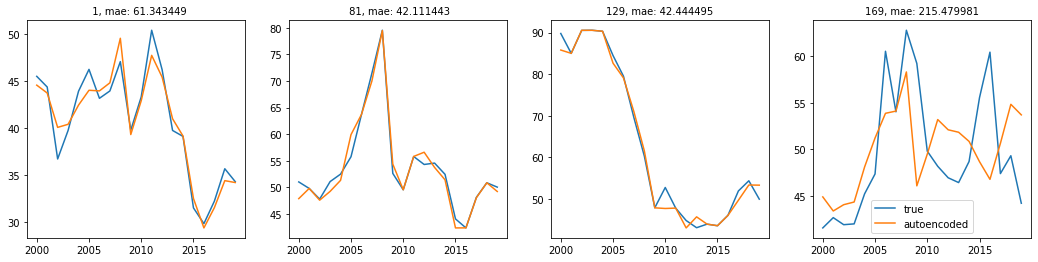

Military expenditure (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 101.4420
Loss: 68.510521. Before fine-tuning: 101.442009


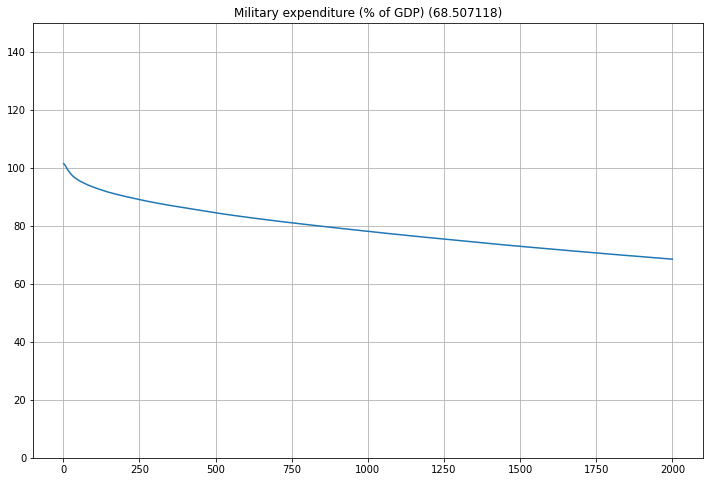

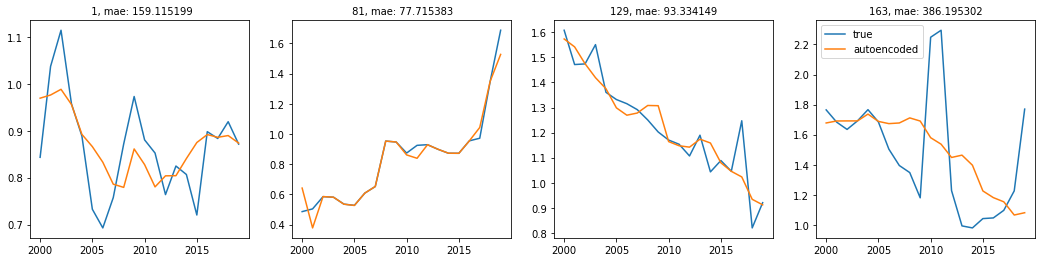

Mortality rate, under-5 (per 1,000 live births)
6/6 [==============================] - 0s 5ms/step - loss: 14.8568
Loss: 11.274881. Before fine-tuning: 14.856759


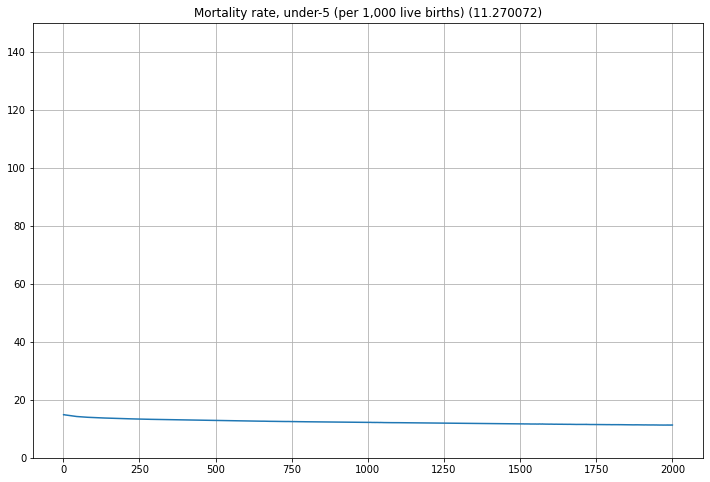

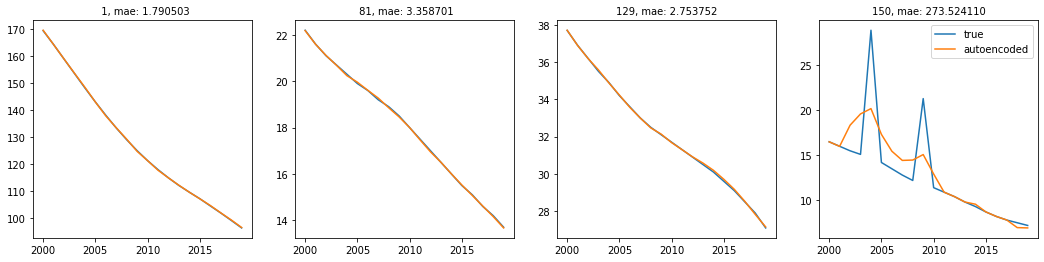

Population growth (annual %)
6/6 [==============================] - 0s 3ms/step - loss: 67.1658
Loss: 37.201767. Before fine-tuning: 67.165771


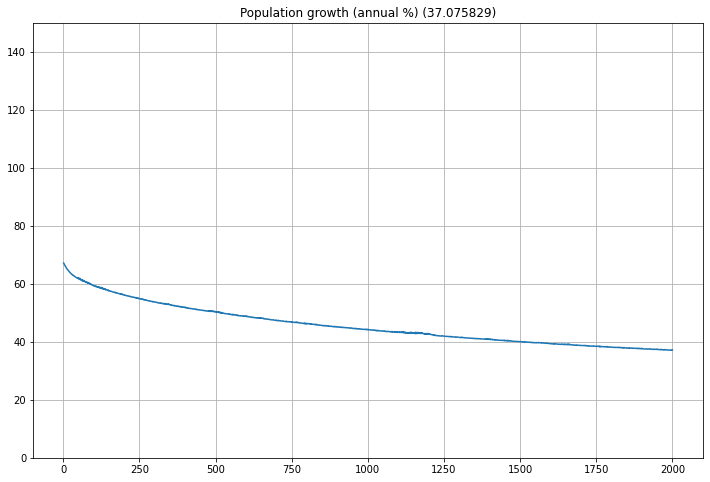

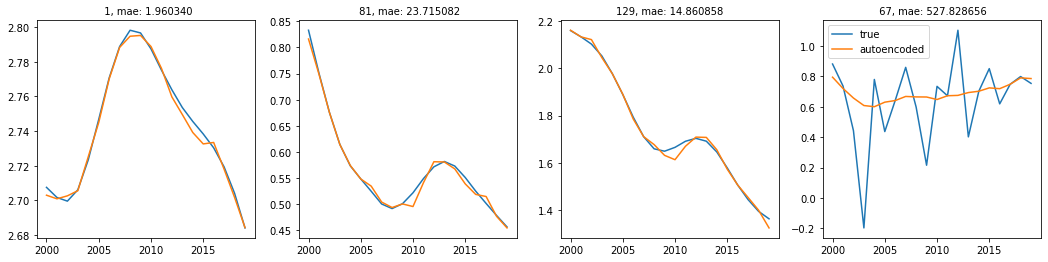

Population in the largest city (% of urban population)
6/6 [==============================] - 0s 5ms/step - loss: 4.2578
Loss: 3.226114. Before fine-tuning: 4.257829


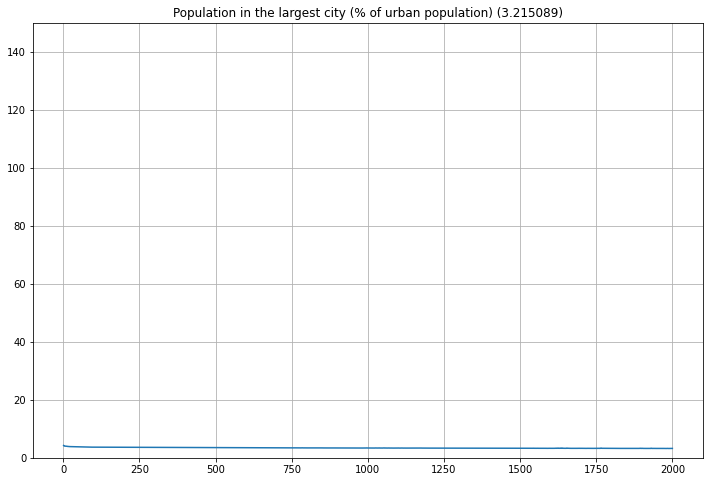

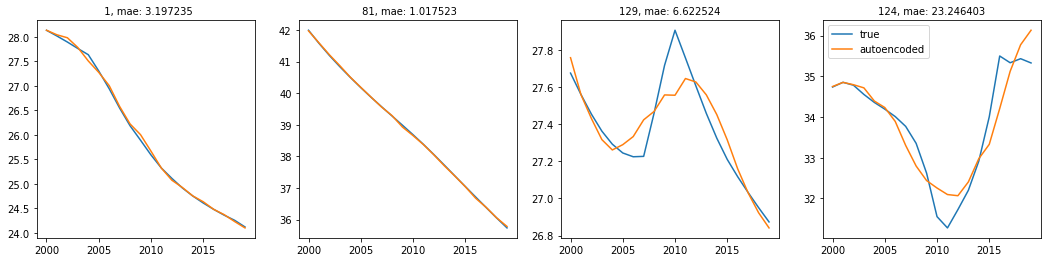

Total natural resources rents (% of GDP)
6/6 [==============================] - 0s 3ms/step - loss: 142.1027
Loss: 98.652374. Before fine-tuning: 142.102722


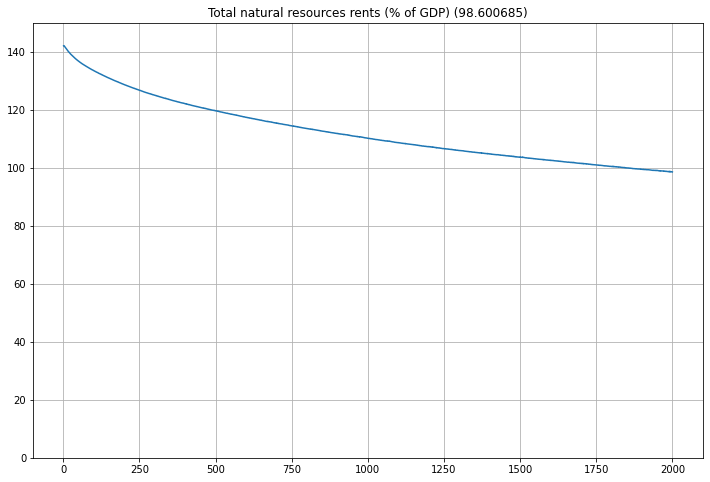

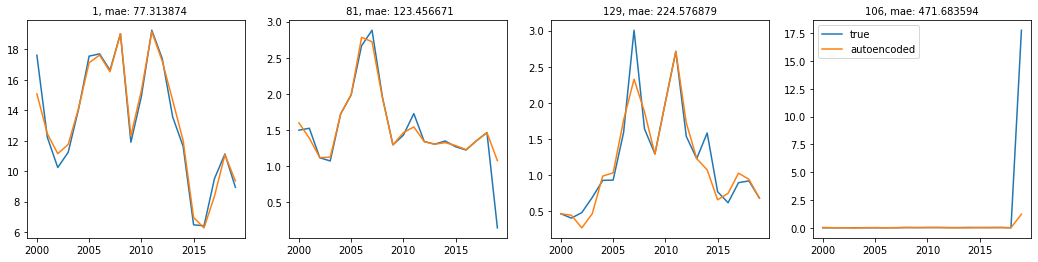

Unemployment, total (% of total labor force) (modeled ILO estimate)
6/6 [==============================] - 0s 5ms/step - loss: 75.1735
Loss: 52.399021. Before fine-tuning: 75.173477


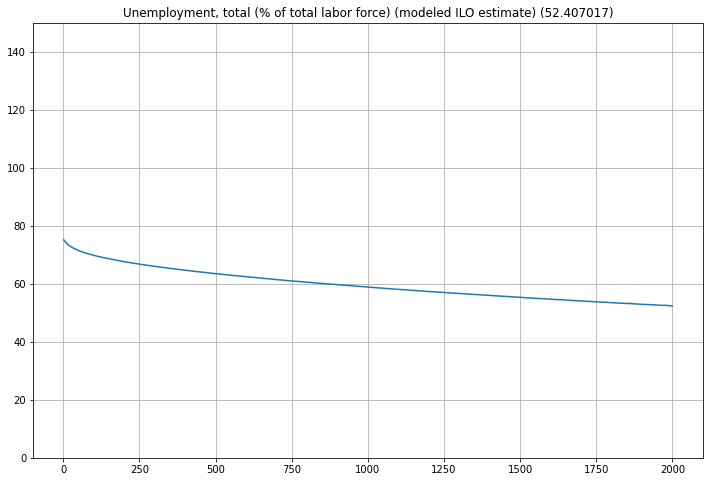

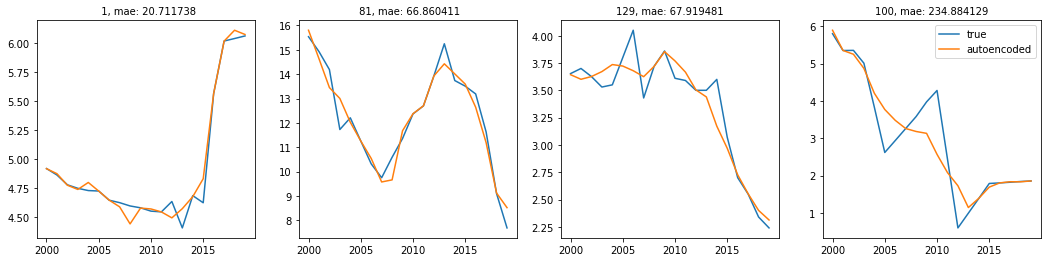

In [16]:
for feature, X in list(time_series_dict.items()):
    print('===========================================================================================================================================')
    print(feature)
    print('===========================================================================================================================================')
    
    model_path = f'{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/{feature}'
    autoencoder = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=model_path).load_weights()
    
    print(f'Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}')
    
    plot_history(autoencoder.history, feature, ymax=150)
    plot_autoencoded(autoencoder, X, indices=[1, 81, 129], rows=1, cols=4, figsize=(18, 4))